In [50]:
import os
import itertools
import glob
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import openpyxl
import matplotlib.ticker
import matplotlib.pyplot as plt


sns.set(font_scale=1.2, style='whitegrid', font='CMU Sans Serif')

# # drawio colors
# # 189,215,238
# # 255,230,153
# pal = sns.color_palette(['#BDD7EE', '#FFE699'])
sns.set_palette("muted", 9)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,2)
mpl.rcParams['figure.dpi'] = 100

existing_dir_zh = 'zh-figures'
existing_dir_en = 'en-figures'
existing_dir_language = 'language-compare-figures'

In [51]:
def process_sheet(sheet_name):
    excel_raw_df = pd.read_excel('./result_copy.xlsx', sheet_name=sheet_name)

    name_line = excel_raw_df.head(1).dropna(axis=1, how='any')
    pass_rate_df = excel_raw_df[excel_raw_df['Index'].str.contains('PASS RATE') == True].dropna(axis=1, how='any')
    compile_rate_df = excel_raw_df[excel_raw_df['Index'].str.contains('COMPILABLE RATE') == True].dropna(axis=1, how='any')

    raw_combined_df = pd.concat([name_line, pass_rate_df, compile_rate_df], ignore_index=True)

    # Get values
    models = raw_combined_df.iloc[0, 0:6].values
    pass_rate = raw_combined_df.iloc[1, 0:6].values * 100
    compilable_rate = raw_combined_df.iloc[2, 0:6].values * 100

    task_map = {
        'Remote Control': 'Remote Device Control',
        'Fixed Plans': 'Scheduled Plans',
        'Auto Adapt': 'Comfort Home',
        'Energy Saving': 'Energy Efficient Home',
    }

    model_map = {
        'gpt-4o': 'GPT-4o',
        # 'gpt-3.5-16k': 'GPT-3.5-Turbo',
        'gpt-4o-mini': 'GPT-4o-mini',
        'gemini': 'Gemini',
        'llama3': 'Llama',
        'copilot': 'Copilot',
    }

    type_map = {
        'PASS RATE': 'Ready-to-Use Rate',
        'COMPILABLE RATE': 'Compile Rate',
    }

    mapped_models = [model_map.get(model, model) for model in models]
    task_name = task_map.get(sheet_name, sheet_name)

    # Add Task Name
    data = {
        'Model': list(mapped_models) * 2,
        'Rate': list(pass_rate) + list(compilable_rate),
        'Type': [type_map['PASS RATE']] * len(models) + [type_map['COMPILABLE RATE']] * len(mapped_models),
        'Task': task_name,
    }
    return pd.DataFrame(data)

# Sheet Names
sheet_names = ['Fixed Plans', 'Energy Saving', 'Remote Control', 'Auto Adapt']
all_dataframes = [process_sheet(sheet_name) for sheet_name in sheet_names]

# Data Frame containing all the data from the Excel
final_df = pd.concat(all_dataframes, ignore_index=True)
final_df['Language'] = 'Chinese'
#
# print(final_df)
final_df.to_csv('final_df.csv', index=False)

In [52]:
# delete gpt3.5 data and sort data by task
task_order = ["Remote Device Control", 'Scheduled Plans', "Comfort Home", "Energy Efficient Home"]

final_df = final_df[~final_df['Model'].str.contains('GPT-3.5', case=False, na=False)]
final_df['Task'] = pd.Categorical(final_df['Task'], categories=task_order, ordered=True)

print(final_df)

          Model       Rate               Type                   Task Language
0        GPT-4o  81.538462  Ready-to-Use Rate        Scheduled Plans  Chinese
2   GPT-4o-mini  43.939394  Ready-to-Use Rate        Scheduled Plans  Chinese
3        Gemini  24.242424  Ready-to-Use Rate        Scheduled Plans  Chinese
4         Llama   0.000000  Ready-to-Use Rate        Scheduled Plans  Chinese
5       Copilot  31.818182  Ready-to-Use Rate        Scheduled Plans  Chinese
6        GPT-4o  90.769231       Compile Rate        Scheduled Plans  Chinese
8   GPT-4o-mini  69.696970       Compile Rate        Scheduled Plans  Chinese
9        Gemini  45.454545       Compile Rate        Scheduled Plans  Chinese
10        Llama   0.000000       Compile Rate        Scheduled Plans  Chinese
11      Copilot  69.696970       Compile Rate        Scheduled Plans  Chinese
12       GPT-4o  57.142857  Ready-to-Use Rate  Energy Efficient Home  Chinese
14  GPT-4o-mini  28.571429  Ready-to-Use Rate  Energy Efficient 

In [54]:
final_en_df = pd.read_csv('final_df_en.csv')
tasks = final_en_df['Task'].unique()

for task in tasks:
    task_df_en = final_en_df[final_en_df['Task'] == task]

task_order = ["Remote Device Control", 'Scheduled Plans', "Comfort Home", "Energy Efficient Home"]
final_en_df['Task'] = pd.Categorical(final_en_df['Task'], categories=task_order, ordered=True)

print(final_en_df)


          Model        Rate               Type                   Task Language
0        GPT-4o   80.000000  Ready-to-Use Rate        Scheduled Plans  English
1   GPT-4o-mini   41.538462  Ready-to-Use Rate        Scheduled Plans  English
2        Gemini    9.230769  Ready-to-Use Rate        Scheduled Plans  English
3         Llama    0.000000  Ready-to-Use Rate        Scheduled Plans  English
4       Copilot   26.153846  Ready-to-Use Rate        Scheduled Plans  English
5        GPT-4o   86.153846       Compile Rate        Scheduled Plans  English
6   GPT-4o-mini   76.923077       Compile Rate        Scheduled Plans  English
7        Gemini   49.230769       Compile Rate        Scheduled Plans  English
8         Llama    0.000000       Compile Rate        Scheduled Plans  English
9       Copilot   43.076923       Compile Rate        Scheduled Plans  English
10       GPT-4o   38.095238  Ready-to-Use Rate  Energy Efficient Home  English
11  GPT-4o-mini   38.095238  Ready-to-Use Rate  Ener

In [64]:
def bar_plot_task_model(data, rate, x_label, hue, existing_dir, show_values=False):
    plot_data = data[data['Type'] == rate]
    g = sns.barplot(data=plot_data, x=x_label, y='Rate', hue=hue)

    handles, labels = g.get_legend_handles_labels()

    if handles and labels:
        legend = plt.legend(
            handles=handles,
            labels=labels,
            loc='lower left',
            bbox_to_anchor=(1,0),
            fontsize=4,          # Adjust font size
            handlelength=1.5,          # Adjust length of legend handles
            handletextpad=0.5,         # Space between handle and text
            borderpad=0.4,             # Padding between legend border and content
            borderaxespad=0.5,         # Padding between legend border and axes
            title=None,      # Add a title if needed
            title_fontsize='medium',    # Font size of the title
            ncol = 1,
            frameon = True,
        )

    if show_values:
        # annotation for barplot
        for p in g.patches:
            height = p.get_height()
            if height != 0 or (height == 0 and isinstance(height, float)):
                g.annotate(f'{height:.2f}%',
                           (p.get_x() + p.get_width() / 2., height),
                           ha='center', va='bottom',
                           xytext=(0.5, 0.5),
                           textcoords='offset points',
                           fontsize=4)

    g.set_title(f"Functions Performance with {rate}")
    g.set_xlabel(f"{x_label}")
    g.set_ylabel(f"{rate} (%)")
    plt.xticks(fontsize=7)

    # save plots
    suffix = '_with_value' if show_values else '_'
    file_path = os.path.join(existing_dir, f"{existing_dir}_{x_label}_{hue}_{rate.lower().replace(' ', '_')}_barplot{suffix}.pdf")

    plt.savefig(file_path, bbox_inches='tight')
    plt.show()


webf NOT subset; don't know how to subset; dropped


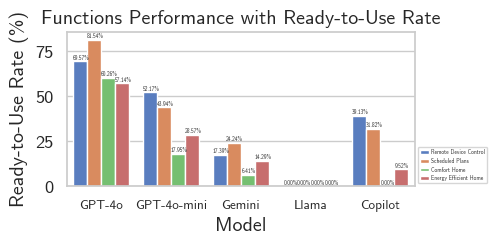

webf NOT subset; don't know how to subset; dropped


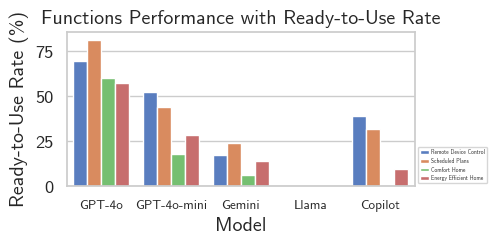

webf NOT subset; don't know how to subset; dropped


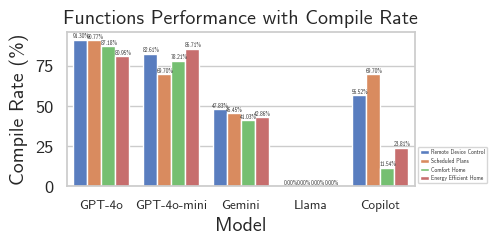

webf NOT subset; don't know how to subset; dropped


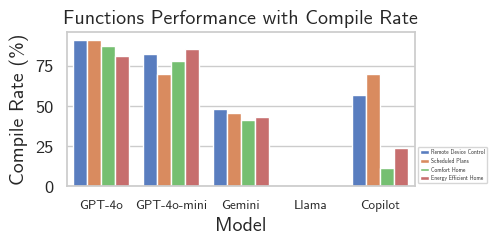

In [56]:
# bar_plot_task_model(final_df, 'PASS RATE', 'Task', 'Model', existing_dir_zh, True)
# bar_plot_task_model(final_df, 'PASS RATE', 'Task', 'Model', existing_dir_zh, False)

# bar_plot_task_model(final_df, 'COMPILABLE RATE', 'Task', 'Model', existing_dir_zh, True)
# bar_plot_task_model(final_df, 'COMPILABLE RATE', 'Task', 'Model', existing_dir_zh, False)
#
# Chinese Experiment Figures
bar_plot_task_model(final_df, 'Ready-to-Use Rate', 'Model', 'Task', existing_dir_zh, True)
bar_plot_task_model(final_df, 'Ready-to-Use Rate', 'Model', 'Task', existing_dir_zh, False)
#
bar_plot_task_model(final_df, 'Compile Rate', 'Model', 'Task', existing_dir_zh, True)
bar_plot_task_model(final_df, 'Compile Rate', 'Model', 'Task', existing_dir_zh, False)


webf NOT subset; don't know how to subset; dropped


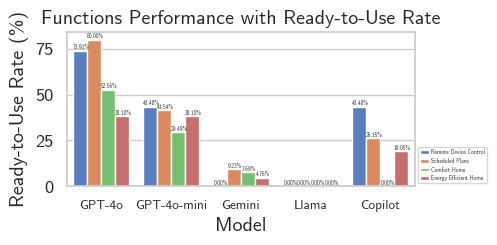

webf NOT subset; don't know how to subset; dropped


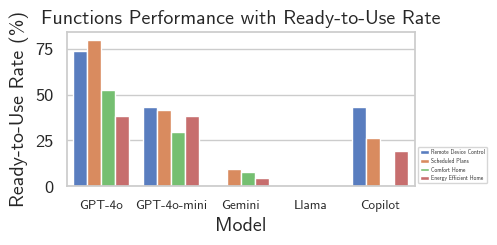

webf NOT subset; don't know how to subset; dropped


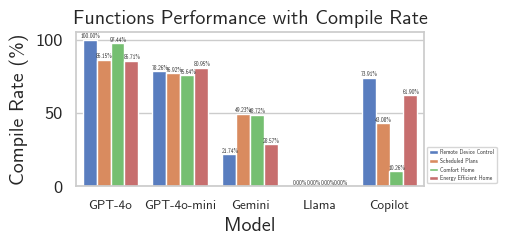

webf NOT subset; don't know how to subset; dropped


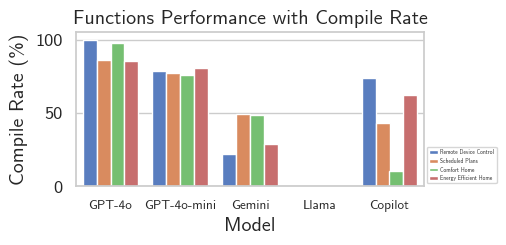

In [57]:
# bar_plot_task_model(final_en_df, 'PASS RATE', 'Task', 'Model', existing_dir_en, True)
# bar_plot_task_model(final_en_df, 'PASS RATE', 'Task', 'Model', existing_dir_en, False)
#
# bar_plot_task_model(final_en_df, 'COMPILABLE RATE', 'Task', 'Model', existing_dir_en, True)
# bar_plot_task_model(final_en_df, 'COMPILABLE RATE', 'Task', 'Model', existing_dir_en, False)
#

# English Experiment Figures
bar_plot_task_model(final_en_df, 'Ready-to-Use Rate', 'Model', 'Task', existing_dir_en, True)
bar_plot_task_model(final_en_df, 'Ready-to-Use Rate', 'Model', 'Task', existing_dir_en, False)
#
bar_plot_task_model(final_en_df, 'Compile Rate', 'Model', 'Task', existing_dir_en, True)
bar_plot_task_model(final_en_df, 'Compile Rate', 'Model', 'Task', existing_dir_en, False)


webf NOT subset; don't know how to subset; dropped


         Model               Type Language       Rate
0      Copilot       Compile Rate  Chinese  40.391674
1      Copilot  Ready-to-Use Rate  Chinese  20.118107
2       GPT-4o       Compile Rate  Chinese  87.551362
3       GPT-4o  Ready-to-Use Rate  Chinese  67.125737
4  GPT-4o-mini       Compile Rate  Chinese  79.056270
5  GPT-4o-mini  Ready-to-Use Rate  Chinese  35.658363
6       Gemini       Compile Rate  Chinese  44.290854
7       Gemini  Ready-to-Use Rate  Chinese  15.582425
8        Llama       Compile Rate  Chinese   0.000000
9        Llama  Ready-to-Use Rate  Chinese   0.000000
0      Copilot       Compile Rate  English  47.287785
1      Copilot  Ready-to-Use Rate  English  22.169932
2       GPT-4o       Compile Rate  English  92.326007
3       GPT-4o  Ready-to-Use Rate  English  61.143096
4  GPT-4o-mini       Compile Rate  English  77.944338
5  GPT-4o-mini  Ready-to-Use Rate  English  38.149785
6       Gemini       Compile Rate  English  37.064819
7       Gemini  Ready-to-Use

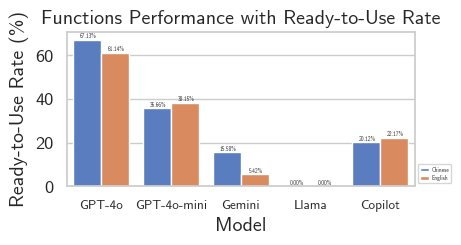

webf NOT subset; don't know how to subset; dropped


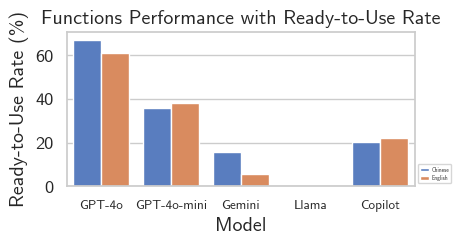

webf NOT subset; don't know how to subset; dropped


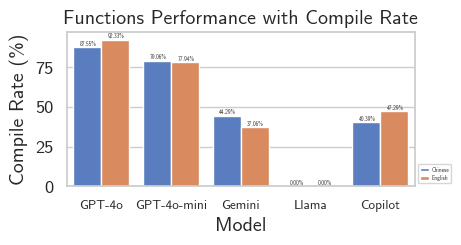

webf NOT subset; don't know how to subset; dropped


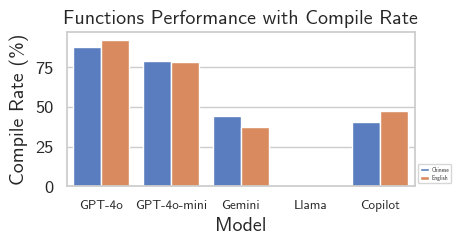

In [59]:
avg_rates_en = final_en_df.groupby(['Model', 'Type', 'Language'])['Rate'].mean().reset_index()
avg_rates_zh = final_df.groupby(['Model', 'Type', 'Language'])['Rate'].mean().reset_index()

merged_df = pd.concat([avg_rates_zh, avg_rates_en])

model_order = ['GPT-4o', 'GPT-4o-mini', 'Gemini', 'Llama', 'Copilot']
merged_df['Model'] = pd.Categorical(merged_df['Model'], categories=model_order, ordered=True)

print(merged_df)

bar_plot_task_model(merged_df, 'Ready-to-Use Rate','Model', 'Language', existing_dir_language, True)
bar_plot_task_model(merged_df, 'Ready-to-Use Rate', 'Model', 'Language',existing_dir_language, False)

bar_plot_task_model(merged_df, 'Compile Rate', 'Model', 'Language',existing_dir_language, True)
bar_plot_task_model(merged_df, 'Compile Rate', 'Model', 'Language',existing_dir_language, False)

In [9]:
# plot_cat(merged_df, 'Model', 'Type', 'Language', existing_dir_language, False)
# plot_cat(merged_df, 'Model', 'Type', 'Language', existing_dir_language, True)

In [10]:
# plot_cat(merged_df, 'Model', 'Language', 'Type', existing_dir_language, False)
# plot_cat(merged_df, 'Model', 'Language', 'Type', existing_dir_language, True)

webf NOT subset; don't know how to subset; dropped


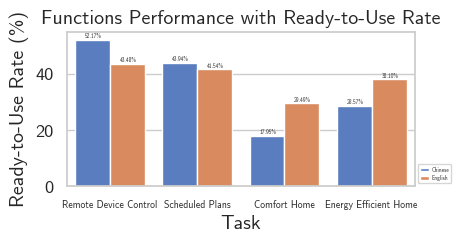

webf NOT subset; don't know how to subset; dropped


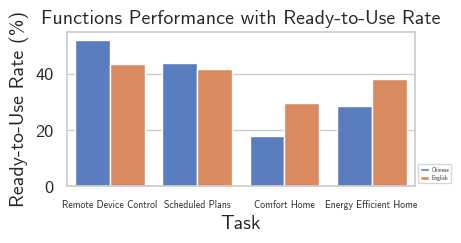

webf NOT subset; don't know how to subset; dropped


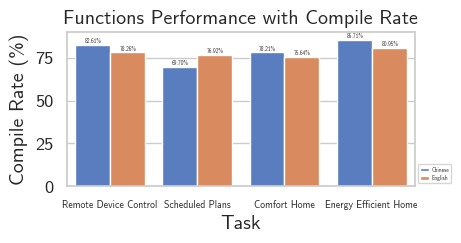

webf NOT subset; don't know how to subset; dropped


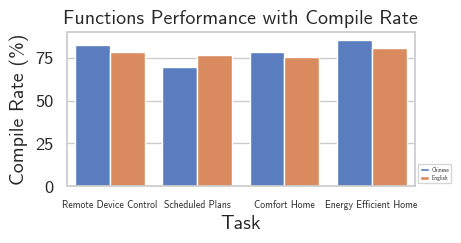

In [68]:
all_df = pd.concat([final_df, final_en_df])
#
gpt4o_df = all_df[all_df['Model'] == 'GPT-4o']
gemini_df = all_df[all_df['Model'] == 'Gemini']
copilot_df = all_df[all_df['Model'] == 'Copilot']
gpt4o_mini_df = all_df[all_df['Model'] == 'GPT-4o-mini']


def language_compaison_plot(model_df):
    bar_plot_task_model(model_df, 'Ready-to-Use Rate', 'Task', 'Language', existing_dir_language, True)
    bar_plot_task_model(model_df, 'Ready-to-Use Rate', 'Task', 'Language', existing_dir_language, False)
    bar_plot_task_model(model_df, 'Compile Rate', 'Task', 'Language', existing_dir_language, True)
    bar_plot_task_model(model_df, 'Compile Rate', 'Task', 'Language', existing_dir_language, False)


# language_compaison_plot(gpt4o_df)
# language_compaison_plot(gemini_df)
# language_compaison_plot(copilot_df)
language_compaison_plot(gpt4o_mini_df)



In [31]:
# # cat plot
# def plot_cat(data, x_label, hue, col, existing_dir, show_values=False):
#     g = sns.catplot(
#         data=data,
#         x=x_label,
#         y='Rate',
#         hue=hue,
#         col=col,
#         kind='bar',
#         height=5,
#         aspect=2
#     )
#
#     if existing_dir.__contains__('en'):
#         g.set_titles("{col_name} by Task in English")
#     elif existing_dir.__contains__('zh'):
#         g.set_titles("{col_name} by Task in Chinese")
#     elif hue == 'Language':
#         g.set_titles("Average {col_name}")
#     else:
#         # todo:
#         g.set_titles("Task in {col_name}")
#
#     if x_label == 'Model':
#         g.set_axis_labels('LLM Models', "Percentage (%)")
#     elif x_label == 'Task':
#         g.set_axis_labels('Tasks', "Percentage (%)")
#     else:
#         g.set_axis_labels(x_label, "Percentage (%)")
#
#
#     g._legend.set_bbox_to_anchor((1, 0.5))
#
#     if show_values:
#         # comment this for loop if you don't want to annotate the bars
#         for ax in g.axes.flat:
#             for p in ax.patches:
#                 height = p.get_height()
#
#                 # Only annotate if the height is not exactly 0 (but allow 0.0)
#                 if height != 0 or (height == 0 and isinstance(height, float)):
#                     ax.annotate(f'{height:.2f}%',
#                                 (p.get_x() + p.get_width() / 2., height),
#                                 ha='center', va='bottom',
#                                 xytext=(0, 0),
#                                 textcoords='offset points',
#                                 fontsize=9,)
#         file_path = os.path.join(existing_dir, f"{existing_dir}_all_{x_label.lower()}_{hue.lower()}_catplot_with_values.pdf")
#
#     else:
#         file_path = os.path.join(existing_dir, f"{existing_dir}_all_{x_label.lower()}_{hue.lower()}_catplot.pdf")
#
#
#     plt.savefig(file_path, bbox_inches='tight')
#     plt.show()
#
#
# # plot_cat(final_df, 'Task', 'Model', 'Type', existing_dir_zh, True)
# # plot_cat(final_df, 'Task', 'Model', 'Type', existing_dir_zh, False)
# #
# # plot_cat(final_df, 'Model', 'Task', 'Type', existing_dir_zh, False)
# # plot_cat(final_df, 'Model', 'Task', 'Type', existing_dir_zh, True)

          Model       Rate               Type                   Task
0        GPT-4o  81.538462  Ready-to-Use Rate        Scheduled Plans
2   GPT-4o-mini  43.939394  Ready-to-Use Rate        Scheduled Plans
3        Gemini  24.242424  Ready-to-Use Rate        Scheduled Plans
4         Llama   0.000000  Ready-to-Use Rate        Scheduled Plans
5       Copilot  31.818182  Ready-to-Use Rate        Scheduled Plans
6        GPT-4o  90.769231       Compile Rate        Scheduled Plans
8   GPT-4o-mini  69.696970       Compile Rate        Scheduled Plans
9        Gemini  45.454545       Compile Rate        Scheduled Plans
10        Llama   0.000000       Compile Rate        Scheduled Plans
11      Copilot  69.696970       Compile Rate        Scheduled Plans
12       GPT-4o  57.142857  Ready-to-Use Rate  Energy Efficient Home
14  GPT-4o-mini  28.571429  Ready-to-Use Rate  Energy Efficient Home
15       Gemini  14.285714  Ready-to-Use Rate  Energy Efficient Home
16        Llama   0.000000  Ready-

In [25]:
# # barplot
# def plot_bar(data, task, existing_dir, show_values=False):
#     g = sns.barplot(data=data, x='Model', y='Rate', hue='Type')
#     # g = sns.barplot(data=data, x = 'Type', y = 'Rate', hue = 'Model')
#
#     # annotation for barplot
#     if show_values:
#         for p in g.patches:
#             height = p.get_height()
#             if height != 0 or (height == 0 and isinstance(height, float)):
#                 g.annotate(f'{height:.2f}%',
#                            (p.get_x() + p.get_width() / 2., height),
#                            ha='center', va='bottom',
#                            xytext=(0, 0),
#                            textcoords='offset points',
#                            fontsize=5)
#     # legend format
#     handles, labels = g.get_legend_handles_labels()
#     if handles and labels:
#         legend = plt.legend(
#             handles=handles,
#             labels=['Pass' if lbl == 'PASS RATE' else 'Compilable' for lbl in labels],
#             loc='lower left',
#             bbox_to_anchor=(1, 0),
#             fontsize=4,
#             handlelength=1.5,
#             handletextpad=0.5,
#             borderpad=0.4,
#             borderaxespad=0.5,
#             ncol=1,
#             frameon=True,
#         )
#
#     # title and label
#     g.set_title(f"Functions Performance with {task} Task")
#     g.set_xlabel('LLM Models')
#     g.set_ylabel('Rate (%)')
#     plt.xticks(fontsize=6)
#
#     # save plots
#     suffix = '_with_value' if show_values else '_'
#     file_path = os.path.join(existing_dir, f"{existing_dir}_{task.lower().replace(' ', '_')}_barplot{suffix}.pdf")
#     plt.savefig(file_path, bbox_inches='tight')
#     plt.show()
#
# # lineplot
# def plot_line(data, task, existing_dir, show_values=False):
#     g = sns.lineplot(data=data, x='Model', y='Rate', hue='Type', markers=True, style='Type')
#
#     # annotation for lineplot
#     if show_values:
#         for line in g.lines:
#             for x, y in zip(line.get_xdata(), line.get_ydata()):
#                 g.annotate(f'{y:.1f}',
#                            xy=(x, y),
#                            xytext=(6, 0),
#                            textcoords='offset points',
#                            ha='center',
#                            va='bottom',
#                            fontsize=5,
#                            bbox=dict(facecolor='white', edgecolor='none', alpha=0.5, boxstyle='round,pad=0.1'))
#
#     # legend format
#     handles, labels = g.get_legend_handles_labels()
#     if handles and labels:
#         legend = plt.legend(
#             handles=handles,
#             labels=['Pass' if lbl == 'PASS RATE' else 'Compilable' for lbl in labels],
#             loc='lower left',
#             bbox_to_anchor=(1, 0),
#             fontsize=4,
#             handlelength=1.5,
#             handletextpad=0.5,
#             borderpad=0.4,
#             borderaxespad=0.5,
#             ncol=1,
#             frameon=True,
#         )
#
#     # title and label
#     g.set_title(f"Functions Performance with {task} Task")
#     g.set_xlabel('LLM Models')
#     g.set_ylabel('Rate (%)')
#     plt.xticks(fontsize=6)
#
#     # save plots
#     suffix = '_with_value' if show_values else '_'
#     file_path = os.path.join(existing_dir, f"{existing_dir}_{task.lower().replace(' ', '_')}_lineplot{suffix}.pdf")
#     plt.savefig(file_path, bbox_inches='tight')
#     plt.show()
#
#
# # task data
# tasks = final_df['Task'].unique()
#
# for task in tasks:
#
#     task_df = final_df[final_df['Task'] == task]
#     task_df = task_df[~task_df['Model'].str.contains('GPT-3.5', case=False, na=False)]
#
#     # plot_bar(task_df, task, existing_dir_zh, show_values=False)
#     # plot_bar(task_df, task, existing_dir_zh, show_values=True)
#     # plot_line(task_df, task, existing_dir_zh, show_values=False)
#     # plot_line(task_df, task, existing_dir_zh, show_values=True)